In [ ]:
# 1. Install the required packages

!wget https://raw.githubusercontent.com/jomo0825/MrFuGenerativeAI/main/requirements.txt
!pip install -r requirements.txt

print("Package installation finished.")


In [1]:
# 2. Create folders and download training scripts
import os, shutil

dataset_dir = "./dataset"
output_dir = "./output"
logging_dir = "./logs"
class_dir = "./class"

token_name = "sks"
pipeline = None

def reset_data():
  # Create the directories if they don't exist
  os.makedirs(dataset_dir, exist_ok=True)
  # Delete the 'output' folder and its contents
  shutil.rmtree(output_dir, ignore_errors=True)
  os.makedirs(output_dir, exist_ok=True)
  os.makedirs(os.path.join(output_dir, "images" ), exist_ok=True)
  # Delete the 'log' folder and its contents
  shutil.rmtree(logging_dir, ignore_errors=True)
  os.makedirs(logging_dir, exist_ok=True)
  # Delete the 'class' folder and its contents
  # shutil.rmtree(class_dir, ignore_errors=True)
  os.makedirs(class_dir, exist_ok=True)
  # Delete the 'dataset' folder and its contents
  # shutil.rmtree(dataset_dir, ignore_errors=True)
  # os.makedirs(dataset_dir, exist_ok=True)

  # fetch train_dreambooth.py if it doesn't exist
  if not os.path.exists("train_dreambooth.py"):
      !wget https://raw.githubusercontent.com/jomo0825/MrFuGenerativeAI/main/Dreambooth/train_dreambooth.py
  else:
      print("train_dreambooth.py already exists, skipping download.")

  # fetch convertosdv2.py if it doesn't exist
  if not os.path.exists("convert_diffusers_to_original_stable_diffusion.py"):
      !wget https://raw.githubusercontent.com/jomo0825/MrFuGenerativeAI/main/utils/convert_diffusers_to_original_stable_diffusion.py
  else:
      print("convert_diffusers_to_original_stable_diffusion.py already exists, skipping download.")

  ipynb_checkpoints = os.path.join( dataset_dir, ".ipynb_checkpoints")
  shutil.rmtree(".gradio", ignore_errors=True)
  shutil.rmtree(".config", ignore_errors=True)
  shutil.rmtree(ipynb_checkpoints, ignore_errors=True)

reset_data()

train_dreambooth.py already exists, skipping download.
convert_diffusers_to_original_stable_diffusion.py already exists, skipping download.


In [ ]:
# 3. Create a WebUI for training
# It will download the SD v1.5 for the 1st time training
# A very good reference:
# https://www.reddit.com/r/StableDiffusion/comments/ybxv7h/good_dreambooth_formula/
import importlib
import train_dreambooth

# Force reload
importlib.reload(train_dreambooth)

import gradio as gr
import sys
import threading
from train_dreambooth import main as train_dreambooth
from train_dreambooth import parse_args
import time, os, logging
from os import path
import subprocess
import shlex
import queue
from PIL import Image

def parse_lr_schedule(lr_schedule_str):
    schedule = []
    segments = lr_schedule_str.split(',')
    for segment in segments:
        if ':' in segment:
            lr, steps = segment.split(':')
            schedule.append((float(lr), int(steps)))
        else:
            schedule.append((float(segment), None))  # Final constant learning rate
    return schedule

def get_learning_rate_at_step(lr_schedule, step):
    current_step = 0
    for lr, segment_steps in lr_schedule:
        if segment_steps is None or step < current_step + segment_steps:
            return lr
        current_step += segment_steps
    return lr_schedule[-1][0]  # Return the last LR if beyond defined steps

# Callback to update the preview image in the UI
def preview_callback(image, step):
    global current_preview, current_status, max_train_steps, current_step
    current_step = step
    if image is not None:
        current_preview = image
        image.save(os.path.join(output_dir, "images", f"image_{step}.png"))
    # print(f"{step}/{max_train_steps}")
    
def stop_training():
  global stop_flag
  stop_flag.set()
  return gr.update(value="Training will be stopped...Waiting for the final preview...")

def run_training(prompt, placeholder_token, class_token, num_training_steps,
                 learning_rate, batch_size, preview_save_steps, preview_seed):
    global current_preview, current_status, max_train_steps, token_name
    global current_step, finish_event, stop_flag, pipeline
    current_preview = None  # Reset the preview
    current_status = "Training started..."  # Initial status
    token_name = placeholder_token
    pipeline = None

    # Define DreamBooth training parameters as a list of command-line arguments.
    # Adjust the paths, prompts, and hyperparameters to match your experiment.
    command = [
        # "accelerate", "launch", "train_dreambooth.py",
        "--pretrained_model_name_or_path", "stable-diffusion-v1-5/stable-diffusion-v1-5",  # or your chosen model
        "--instance_data_dir", dataset_dir,  # folder with your subject images
        "--instance_prompt", placeholder_token,  # prompt identifier for your subject
        "--output_dir", output_dir,          # where to save your DreamBooth model
        "--train_batch_size", str(batch_size),
        "--resolution", "512",
        "--lr_scheduler", "cosine",
        "--learning_rate", str(float(learning_rate)),
        "--lr_warmup_steps", "0",
        "--gradient_accumulation_steps", "1",
        "--num_validation_images", "1",
        "--validation_prompt", prompt,
        "--validation_steps", str(preview_save_steps),
        "--max_train_steps", str(num_training_steps),
        "--mixed_precision", "fp16",
        "--use_8bit_adam",
        "--gradient_checkpointing",
        "--enable_xformers_memory_efficient_attention",
        "--set_grads_to_none",
        "--logging_dir", logging_dir,
        "--seed", str(preview_seed),
        "--checkpointing_steps", str(num_training_steps+1),

        "--class_data_dir", class_dir,        # folder with class images (for prior preservation)
        "--class_prompt", class_token,        # prompt for class images
        "--with_prior_preservation",           # enable prior preservation if you have class images
        "--num_class_images", "10",           # adjust based on your available class images
        # Add other DreamBooth parameters as needed
    ]

    args = parse_args(command)
    max_train_steps = args.max_train_steps

    # Print the command for debugging
    print("Command:", " ".join(command))

    # Disable logging
    logging.getLogger("accelerate").disabled = True

    # Run the command in a separate process
    # global process
    # process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    def worker(finish_event, stop_flag):
      try:
        train_dreambooth(args, {"_callback": preview_callback, "stop_flag": stop_flag})
      except Exception as e:
        print(f"Training error: {e}")
      finally:
        finish_event.set()

    finish_event = threading.Event()
    stop_flag = threading.Event()
    finish_event.clear()
    stop_flag.clear()

    train_thread = threading.Thread(target=worker, args=(finish_event, stop_flag))
    train_thread.start()
    yield gr.update(value=None), gr.update(value=f"Training started.")
    current_step = None
    while not finish_event.is_set():
        if current_preview is not None:
            yield gr.update(value=current_preview), gr.update(value=f"Preview at {current_step} step.")
            current_preview = None
        time.sleep(1)

    train_thread.join()

    # Update status when training completes
    current_status = "Converting model..."
    yield gr.update(value=current_preview), gr.update(value=current_status)
    # global pipeline
    pipeline=None
    #!python convert_diffusers_to_original_stable_diffusion.py --model_path {output_dir} --checkpoint_path model.safetensors --use_safetensors

    current_status = "Training completed!"
    # process.kill()
    yield gr.update(value=current_preview), gr.update(value=current_status)

# Define a function to move the selected file
def copy_file(target_directory, file_path):
  if file_path is not None:
      filename = os.path.basename(file_path)
      destination_path = os.path.join(target_directory, filename)
      # test if the destination_path alread exist
      if not os.path.exists(destination_path):
        shutil.copy(file_path, destination_path)
        print(f"Copy {filename} to {target_directory}")
      else:
        print(f"{filename} already exists.")
  else:
      print("No file selected.")

def process_files(files):
    file_info = []

    for file in files:
        fileBasename = os.path.basename(file)
        destination_path = os.path.join(dataset_dir, fileBasename)
        if not os.path.exists(destination_path):
            file_info.append(f"File: {file.name}")
            copy_file(dataset_dir, file.name )
    return f"{len(file_info)} files uploaded."

def process_class_files(files):
    file_info = []

    for file in files:
        fileBasename = os.path.basename(file)
        destination_path = os.path.join(class_dir, fileBasename)
        if not os.path.exists(destination_path):
            file_info.append(f"File: {file.name}")
            copy_file(class_dir, file.name )
    return f"{len(file_info)} files uploaded."

def delete_dataset():
  shutil.rmtree(dataset_dir, ignore_errors=True)
  os.makedirs(dataset_dir, exist_ok=True)
  return "Dataset deleted."

def delete_class_images():
  shutil.rmtree(class_dir, ignore_errors=True)
  os.makedirs(class_dir, exist_ok=True)
  return "Class images deleted."

def combine_unet_to_pretrain(
    revision=None,
    variant=None,
    safe_serialization=True,
    **pipeline_args,
):
    """
    Loads a base pipeline, swaps in the UNet saved by `save_unet`, normalizes scheduler,
    and saves a full DiffusionPipeline to out_dir/.
    """
    from diffusers import DiffusionPipeline, UNet2DConditionModel
    
    # Load base pipeline (text encoder, VAE, scheduler, etc.)
    pipe = DiffusionPipeline.from_pretrained(
        "stable-diffusion-v1-5/stable-diffusion-v1-5",
        revision=revision,
        variant=variant,
        **pipeline_args,
    )

    # Load your trained UNet and plug it in
    new_unet = UNet2DConditionModel.from_pretrained(os.path.join(output_dir, "unet"))
    
    pipe.unet = new_unet

    # (Optional) Normalize scheduler variance behavior (same logic you had)
    scheduler_args = {}
    if "variance_type" in pipe.scheduler.config:
        vtype = pipe.scheduler.config.variance_type
        if vtype in ["learned", "learned_range"]:
            vtype = "fixed_small"
        scheduler_args["variance_type"] = vtype
    pipe.scheduler = pipe.scheduler.from_config(pipe.scheduler.config, **scheduler_args)

    # Save the full pipeline
    pipe.save_pretrained(output_dir, safe_serialization=safe_serialization)
    print(f"[combine_unet_to_pretrain] Full pipeline saved to: {output_dir}")
    !python convert_diffusers_to_original_stable_diffusion.py --model_path {output_dir} --checkpoint_path model.safetensors --use_safetensors
    print(f"model.safetensors is created.")

def ui():
    with gr.Blocks() as demo:
        gr.Markdown("# Stable Diffusion Dreambooth WebUI")
        gr.Markdown("Train Stable Diffusion model using preloaded weights.")
        with gr.Row():
          with gr.Column():
            with gr.Row():
                file_input = gr.File(file_count="multiple", label="Upload Dataset",
                  height=200, file_types=["image"])
            with gr.Row():
                submit_btn = gr.Button("Upload Dataset")
                delete_data_btn = gr.Button("Delete Dataset")
            with gr.Row():
                output = gr.Textbox(label="Results")
            submit_btn.click(fn=process_files, inputs=file_input, outputs=output)
            delete_data_btn.click(fn=delete_dataset, outputs=output)
          with gr.Column():
            with gr.Row():
                class_file_input = gr.File(file_count="multiple", label="Upload Class Images",
                  height=200, file_types=["image"])
            with gr.Row():
                class_submit_btn = gr.Button("Upload Class Images")
                class_delete_data_btn = gr.Button("Delete Class Images")
            with gr.Row():
                class_output = gr.Textbox(label="Results")
            class_submit_btn.click(fn=process_class_files, inputs=class_file_input, outputs=class_output)
            class_delete_data_btn.click(fn=delete_class_images, outputs=class_output)

        with gr.Row():
            with gr.Column(scale=1, min_width=300):
                placeholder_token = gr.Textbox(label="Placeholder Token", placeholder="Enter placeholder token here", interactive=True)
                class_token = gr.Textbox(label="Class Token", placeholder="Enter class token here", interactive=True)
                prompt = gr.Textbox(label="Preview Prompt", placeholder="Enter your prompt here", interactive=True)
                num_training_steps = gr.Number(label="Number of Training Steps", value=700, interactive=True)
                learning_rate = gr.Textbox(label="Learning Rate", value="5e-6", interactive=True)
                batch_size = gr.Number(label="Batch Size", value=2, interactive=True)
                preview_save_steps = gr.Number(label="Preview Steps", value=25, interactive=True)
                preview_seed = gr.Number(label="Preview Seed", value=1, interactive=True)
            with gr.Column(scale=1, min_width=300):
                output_image = gr.Image(label="Generated Image")
                generate_status = gr.Textbox(value="Status messages will appear here.", label="Status", interactive=False)
                generate_button = gr.Button("Start Training")
                cancel_button = gr.Button("Cancel Training")
                reset_button = gr.Button("Reset Data")
                save_button = gr.Button("Save Model")

        generate_button.click(
            fn=run_training,
            inputs=[prompt, placeholder_token, class_token, num_training_steps,
                    learning_rate, batch_size, preview_save_steps, preview_seed],
            outputs=[output_image, generate_status],
            show_progress=True,
            queue=True
        )

        cancel_button.click(
            fn=stop_training,
            outputs=[generate_status]
        )

        reset_button.click(
            fn=reset_data
        )
        
        save_button.click(
            fn=combine_unet_to_pretrain
        )

    return demo

demo = ui()
demo.launch(share=True, debug=True)
# demo.launch(debug=True)


* Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\NTUT_mrfu\miniconda3\envs\mrfuGAI\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Traceback (most recent call last):
  File "c:\Users\NTUT_mrfu\miniconda3\envs\mrfuGAI\lib\site-packages\diffusers\configuration_utils.py", line 390, in load_config
    config_file = hf_hub_download(
  File "c:\Users\NTUT_mrfu\miniconda3\envs\mrfuGAI\lib\site-packages\huggingface_hub\utils\_validators.py", line 106, in _inner_fn
    validate_repo_id(arg_value)
  File "c:\Users\NTUT_mrfu\miniconda3\envs\mrfuGAI\lib\site-packages\huggingface_hub\utils\_validators.py", line 160, in validate_repo_id
    raise HFValidationError(
huggingface_hub.errors.HFValidationError: Repo id must use a

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\NTUT_mrfu\miniconda3\envs\mrfuGAI\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Traceback (most recent call last):
  File "c:\Users\NTUT_mrfu\miniconda3\envs\mrfuGAI\lib\site-packages\diffusers\configuration_utils.py", line 390, in load_config
    config_file = hf_hub_download(
  File "c:\Users\NTUT_mrfu\miniconda3\envs\mrfuGAI\lib\site-packages\huggingface_hub\utils\_validators.py", line 106, in _inner_fn
    validate_repo_id(arg_value)
  File "c:\Users\NTUT_mrfu\miniconda3\envs\mrfuGAI\lib\site-packages\huggingface_hub\utils\_validators.py", line 160, in validate_repo_id
    raise HFValidationError(
huggingface_hub.errors.HFValidationError: Repo id must use a

Keyboard interruption in main thread... closing server.


In [ ]:
# Optional: Loads the logs in TensorBoard
# If you are using Windows, open http://localhost:8888 in browser
# Enable auto update for each 30 seconds, look into Image tab and wait for update.
%load_ext tensorboard
%tensorboard --logdir=logs/ --host localhost --port 8888

  0%|          | 0/30 [00:00<?, ?it/s]

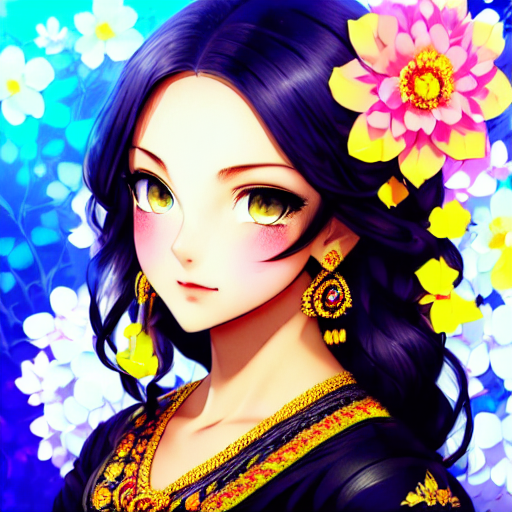

In [ ]:
# Optional: Test the Dreambooth model
from diffusers import StableDiffusionPipeline
import torch

preview_prompt = f"{token_name}, a illustration of wpg. cyan, reflective, flower, 8k, lineart, extremly detailed eyes, digital painting. masterpiece, best quality."
negative_prompt = "grain, pattern, disfigured, kitsch, ugly, oversaturated, grain, low-res, Deformed, blurry, bad anatomy, disfigured, poorly drawn face, mutation, mutated, extra limb, poorly drawn hands, missing limb, blurry, floating limbs, disconnected limbs, malformed hands, blur, out of focus, long neck, long body, disgusting, poorly drawn, childish, mutilated, mangled, old, surreal"

if pipeline is None:
  pipeline = StableDiffusionPipeline.from_single_file(
      "model.safetensors",
      torch_dtype=torch.float16,
  ).to("cuda")

output = pipeline(
    preview_prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7,
)

display(output.images[0])

In [ ]:
demo.close()

In [ ]:
# 4. Download your model.savetensors
# If you are using Colab, you can mount Google Drive and upload your model.safetensors
try:
    from google.colab import drive
    drive.mount('/content/drive')

    # Create a directory in Google Drive if it doesn't exist
    import os
    target_dir = "/content/drive/MyDrive/Dreambooth"
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        print(f"Created directory: {target_dir}")
    else:
        print(f"Directory already exists: {target_dir}")

    # Copy your file to Drive
    !cp /content/model.safetensors {target_dir}/{token_name}.safetensors
    print(f"Your Dreambooth model has been uploaded to your Google Drive folder {target_dir}")
except:
  pass

Mounted at /content/drive
Directory already exists: /content/drive/MyDrive/Dreambooth
Your Dreambooth model has been uploaded to your Google Drive folder /content/drive/MyDrive/Dreambooth
